# Gerador de Tweets utilizando LSTM

## Parte 1 - Extraindo Tweets com GetOldTweets3
Nesta seção, vamos:
 * Extrair tweets, dado nome do usuário e a quantidade de tweets a ser extraido
 * Salvar os dados
 
PS: Em 18/09/2020, o Twitter alterou a saída do endpoint /i/search/timeline, impossibilitando a extração com o GetOldTweets3 após esta data (issue: https://github.com/Mottl/GetOldTweets3/issues/98). Para reproduzir a extração, recomenda-se utilizar o Twitter API, limitado à extração de 5000 tweets por mês.
Na próxima seção, vamos treinar um modelo, utilizando como exemplo os tweets do autor.

In [1]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import GetOldTweets3 as got

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from pickle import dump, load
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import random
random.seed(101)

In [ ]:
#Extração dos tweets

def username_tweets_to_csv(username, count):
    tweetCriteria = got.manager.TweetCriteria().setUsername(username).setMaxTweets(count)
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    tweets_list = [[tweet.date, tweet.text] for tweet in tweets]
    df = pd.DataFrame(tweets_list, columns = ['Datetime', 'Text'])    
    return df

In [ ]:
#Execução da extração

username = 'user_name'
count = 3000

df = username_tweets_to_csv(username, count)


In [ ]:
#Conversão dos dados para csv

df.to_csv(f'{username}-{int(count/1000)}k-tweets.csv', sep=',')

## Parte 2 - Pré-processamento dos dados

Objetivos desta seção:
 * Tratamento e limpeza do texto
 * Criação de séries sequenciais
 * Tokenização dos dados

In [2]:
#Parâmetros:

#Tamanho das sequencias
seq_len = 25

In [3]:
df = pd.read_csv('fastererick-3k-tweets.csv')

In [4]:
df.head(10)

,Datetime,Text
0,2020-08-17 01:04:55+00:00,4 Elites do boy e 3 meus hehe #SmashBros #Nint...
1,2020-06-27 01:26:56+00:00,#AnimalCrossing #ACNH #NintendoSwitch
2,2020-06-19 17:37:42+00:00,#AnimalCrossing #ACNH #NintendoSwitch
3,2020-01-14 21:22:15+00:00,Pra pensar na bad: O que seu personagem favori...
4,2020-01-14 21:08:00+00:00,Medo de largar tudo
5,2020-01-10 14:28:39+00:00,Ainda qro comprar munchkin aaaaaaa
6,2019-12-27 06:25:03+00:00,Perdi
7,2019-12-26 02:06:54+00:00,Paçoca
8,2019-12-25 05:55:31+00:00,Queria tar o 2 contigo hj
9,2019-12-24 23:55:27+00:00,"Psé, Facebook ta uma bosta, mano hahaha'"


In [5]:
df = df.loc[:,'Text']
df

0       4 Elites do boy e 3 meus hehe #SmashBros #Nint...
1                   #AnimalCrossing #ACNH #NintendoSwitch
2                   #AnimalCrossing #ACNH #NintendoSwitch
3       Pra pensar na bad: O que seu personagem favori...
4                                     Medo de largar tudo
                              ...                        
2454    Curioso como o twitter, o orkut e o forms está...
2455    @caasousaa disponha ^^ Ainda sou novo no twitt...
2456                                     Tarja Turunen S2
2457    Domingo tedioso... e podia estar assistindo o ...
2458    Yeah fiz outro Twitter... Aquele outro já tava...
Name: Text, Length: 2459, dtype: object

In [6]:
# Configurações para tratamento do texto

nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
nlp.max_length = 2000000

In [7]:
# Configuração individual de cada tweet
def customize_text(df):
    df = df.str.replace(r'([@#][\w_-]+)',' ')
    df = df.str.lstrip().str.rstrip()
    return df

df = customize_text(df)
df

0                           4 Elites do boy e 3 meus hehe
1                                                        
2                                                        
3       Pra pensar na bad: O que seu personagem favori...
4                                     Medo de largar tudo
                              ...                        
2454    Curioso como o twitter, o orkut e o forms está...
2455    disponha ^^ Ainda sou novo no twitter pegando ...
2456                                     Tarja Turunen S2
2457    Domingo tedioso... e podia estar assistindo o ...
2458    Yeah fiz outro Twitter... Aquele outro já tava...
Name: Text, Length: 2459, dtype: object

In [8]:
# União dos tweets em uma única string
def join_text(df):
    df = df.values
    df_string = ' '.join(df)
    return df_string

df_string = join_text(df)
df_string[0:500]

"4 Elites do boy e 3 meus hehe   Pra pensar na bad: O que seu personagem favorito de filme/jogo diria? Medo de largar tudo Ainda qro comprar munchkin aaaaaaa Perdi Paçoca Queria tar o 2 contigo hj Psé, Facebook ta uma bosta, mano hahaha' Nem pra minha mãe ter esperado pra bater na minha tia crente hj e não no mês passado, aí n tava esse tédio todo aq Tedio ta tao grande aq q ate voltei É aqui o muro das lamentações socialmente aceito? Topo N consegui votar em vc :( Oi Não pode ( ) A ( ) B (X) C o"

In [9]:
# Limpeza das pontuações indesejadas e geração de tokens
def separate_punc(doc_text):
    doc_text = doc_text.replace('...','')
    return [token.text.lower() for token in nlp(doc_text) if token.text not in "\n\n \n\n\n!'\"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n "]

tokens = separate_punc(df_string)
tokens[0:10]

['4', 'elites', 'do', 'boy', 'e', '3', 'meus', 'hehe', '  ', 'pra']

In [10]:
#Geração de tokens sequenciais

train_len = seq_len + 1
text_sequences = []
for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]    
    text_sequences.append(seq)

text_sequences[0]

['4',
 'elites',
 'do',
 'boy',
 'e',
 '3',
 'meus',
 'hehe',
 '  ',
 'pra',
 'pensar',
 'na',
 'bad',
 'o',
 'que',
 'seu',
 'personagem',
 'favorito',
 'de',
 'filme',
 'jogo',
 'diria',
 'medo',
 'de',
 'largar',
 'tudo']

In [11]:
#Conversão de strings para labels numéricos

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)
sequences[0]

[341,
 4879,
 7,
 4878,
 5,
 246,
 245,
 4877,
 6,
 9,
 678,
 15,
 4876,
 3,
 11,
 124,
 4874,
 1294,
 1,
 1988,
 508,
 1987,
 306,
 1,
 4871,
 208]

In [12]:
#Tamanho do vocabulário
vocabulary_size = len(tokenizer.word_counts)
vocabulary_size

4880

In [13]:
#Conversão para array
sequences = np.array(sequences)
sequences[0]

array([ 341, 4879,    7, 4878,    5,  246,  245, 4877,    6,    9,  678,
         15, 4876,    3,   11,  124, 4874, 1294,    1, 1988,  508, 1987,
        306,    1, 4871,  208])

In [14]:
#Criação das variaveis de treino
X = sequences[:,:-1]
y = sequences[:,-1]

In [15]:
X[0]

array([ 341, 4879,    7, 4878,    5,  246,  245, 4877,    6,    9,  678,
         15, 4876,    3,   11,  124, 4874, 1294,    1, 1988,  508, 1987,
        306,    1, 4871])

In [16]:
y[0]

208

In [17]:
# Categorização do y
y = to_categorical(y,num_classes=vocabulary_size+1)
y[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## Parte 3 - Criação do modelo LSTM
Nesta parte, vamos:
 * gerar o modelo LSTM
 * treinar o modelo

In [41]:
#Parâmetros
model_name = 'fastererick_twitter'

In [42]:
#Criação do modelo

def create_model(vocabulary_size, seq_len):  
    model = Sequential()
    model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
    model.add(LSTM(150, return_sequences=True))
    model.add(LSTM(150))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(vocabulary_size,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_model(vocabulary_size+1, seq_len)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 25)            122025    
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 150)           105600    
_________________________________________________________________
lstm_9 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_8 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_9 (Dense)              (None, 4881)              248931    
Total params: 664,706
Trainable params: 664,706
Non-trainable params: 0
_________________________________________________________________


In [43]:
#Treinamento do modelo
history = model.fit(X, y, batch_size=128, epochs=600, verbose=1)

Epoch 1/600
204/204 [==============================] - 19s 93ms/step - loss: 7.2906 - accuracy: 0.0198
Epoch 2/600
204/204 [==============================] - 18s 87ms/step - loss: 6.9493 - accuracy: 0.0192
Epoch 3/600
204/204 [==============================] - 18s 90ms/step - loss: 6.9306 - accuracy: 0.0210
Epoch 4/600
204/204 [==============================] - 18s 89ms/step - loss: 6.9264 - accuracy: 0.0197
Epoch 5/600
204/204 [==============================] - 18s 90ms/step - loss: 6.9243 - accuracy: 0.0214
Epoch 6/600
204/204 [==============================] - 18s 90ms/step - loss: 6.9204 - accuracy: 0.0204
Epoch 7/600
204/204 [==============================] - 18s 90ms/step - loss: 6.8954 - accuracy: 0.0204
Epoch 8/600
204/204 [==============================] - 18s 90ms/step - loss: 6.7772 - accuracy: 0.0255
Epoch 9/600
204/204 [==============================] - 18s 91ms/step - loss: 6.6357 - accuracy: 0.0308
Epoch 10/600
204/204 [==============================] - 18s 90ms/step - l

204/204 [==============================] - 17s 85ms/step - loss: 3.7707 - accuracy: 0.2092
Epoch 79/600
204/204 [==============================] - 17s 85ms/step - loss: 3.7450 - accuracy: 0.2136
Epoch 80/600
204/204 [==============================] - 17s 85ms/step - loss: 3.7232 - accuracy: 0.2166
Epoch 81/600
204/204 [==============================] - 17s 85ms/step - loss: 3.6995 - accuracy: 0.2197
Epoch 82/600
204/204 [==============================] - 17s 85ms/step - loss: 3.6737 - accuracy: 0.2218
Epoch 83/600
204/204 [==============================] - 17s 85ms/step - loss: 3.6517 - accuracy: 0.2262
Epoch 84/600
204/204 [==============================] - 17s 85ms/step - loss: 3.6315 - accuracy: 0.2293
Epoch 85/600
204/204 [==============================] - 17s 85ms/step - loss: 3.6075 - accuracy: 0.2327
Epoch 86/600
204/204 [==============================] - 17s 85ms/step - loss: 3.5853 - accuracy: 0.2384
Epoch 87/600
204/204 [==============================] - 17s 86ms/step - loss:

Epoch 155/600
204/204 [==============================] - 19s 92ms/step - loss: 4.3514 - accuracy: 0.1417
Epoch 156/600
204/204 [==============================] - 19s 92ms/step - loss: 4.1944 - accuracy: 0.1585
Epoch 157/600
204/204 [==============================] - 19s 92ms/step - loss: 4.0857 - accuracy: 0.1718
Epoch 158/600
204/204 [==============================] - 19s 93ms/step - loss: 3.9781 - accuracy: 0.1834
Epoch 159/600
204/204 [==============================] - 19s 92ms/step - loss: 3.8938 - accuracy: 0.19340s - loss: 3.8934 - accuracy
Epoch 160/600
204/204 [==============================] - 19s 93ms/step - loss: 3.8106 - accuracy: 0.2060
Epoch 161/600
204/204 [==============================] - 19s 93ms/step - loss: 3.7377 - accuracy: 0.2165
Epoch 162/600
204/204 [==============================] - 19s 93ms/step - loss: 3.6675 - accuracy: 0.2283
Epoch 163/600
204/204 [==============================] - 19s 93ms/step - loss: 3.6047 - accuracy: 0.2368
Epoch 164/600
204/204 [====

204/204 [==============================] - 20s 96ms/step - loss: 1.5008 - accuracy: 0.6399
Epoch 232/600
204/204 [==============================] - 20s 96ms/step - loss: 1.4181 - accuracy: 0.6611
Epoch 233/600
204/204 [==============================] - 20s 96ms/step - loss: 1.3690 - accuracy: 0.6752
Epoch 234/600
204/204 [==============================] - 20s 96ms/step - loss: 1.3461 - accuracy: 0.6796
Epoch 235/600
204/204 [==============================] - 20s 96ms/step - loss: 1.3240 - accuracy: 0.6873
Epoch 236/600
204/204 [==============================] - 20s 96ms/step - loss: 1.3128 - accuracy: 0.6872
Epoch 237/600
204/204 [==============================] - 20s 96ms/step - loss: 1.3082 - accuracy: 0.6915
Epoch 238/600
204/204 [==============================] - 20s 97ms/step - loss: 1.2871 - accuracy: 0.6918
Epoch 239/600
204/204 [==============================] - 20s 97ms/step - loss: 1.2464 - accuracy: 0.7046
Epoch 240/600
204/204 [==============================] - 20s 96ms/ste

204/204 [==============================] - 20s 97ms/step - loss: 0.1828 - accuracy: 0.9677
Epoch 309/600
204/204 [==============================] - 20s 98ms/step - loss: 0.3655 - accuracy: 0.9065
Epoch 310/600
204/204 [==============================] - 22s 108ms/step - loss: 0.4989 - accuracy: 0.8617
Epoch 311/600
204/204 [==============================] - 22s 107ms/step - loss: 0.4316 - accuracy: 0.8869
Epoch 312/600
204/204 [==============================] - 20s 99ms/step - loss: 0.3449 - accuracy: 0.9181
Epoch 313/600
204/204 [==============================] - 22s 106ms/step - loss: 0.2104 - accuracy: 0.9591
Epoch 314/600
204/204 [==============================] - 23s 111ms/step - loss: 0.1461 - accuracy: 0.9774
Epoch 315/600
204/204 [==============================] - 21s 103ms/step - loss: 0.1087 - accuracy: 0.9864
Epoch 316/600
204/204 [==============================] - 21s 103ms/step - loss: 0.0917 - accuracy: 0.9898
Epoch 317/600
204/204 [==============================] - 23s 11

204/204 [==============================] - 19s 94ms/step - loss: 0.0769 - accuracy: 0.9873
Epoch 385/600
204/204 [==============================] - 19s 95ms/step - loss: 0.0369 - accuracy: 0.9977
Epoch 386/600
204/204 [==============================] - 19s 94ms/step - loss: 0.0241 - accuracy: 0.9993
Epoch 387/600
204/204 [==============================] - 19s 94ms/step - loss: 0.0594 - accuracy: 0.9927
Epoch 388/600
204/204 [==============================] - 19s 94ms/step - loss: 0.0669 - accuracy: 0.9896
Epoch 389/600
204/204 [==============================] - 19s 94ms/step - loss: 0.0787 - accuracy: 0.9863
Epoch 390/600
204/204 [==============================] - 19s 94ms/step - loss: 0.1430 - accuracy: 0.9648
Epoch 391/600
204/204 [==============================] - 19s 94ms/step - loss: 0.2580 - accuracy: 0.9248
Epoch 392/600
204/204 [==============================] - 19s 94ms/step - loss: 0.2148 - accuracy: 0.9389
Epoch 393/600
204/204 [==============================] - 19s 93ms/ste

204/204 [==============================] - 18s 89ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 462/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0017 - accuracy: 1.00001s - l
Epoch 463/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0243 - accuracy: 0.99421s - loss:
Epoch 464/600
204/204 [==============================] - 18s 89ms/step - loss: 2.2969 - accuracy: 0.5667
Epoch 465/600
204/204 [==============================] - 18s 89ms/step - loss: 0.5484 - accuracy: 0.8452
Epoch 466/600
204/204 [==============================] - 18s 89ms/step - loss: 0.1633 - accuracy: 0.9590
Epoch 467/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0578 - accuracy: 0.9900
Epoch 468/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0223 - accuracy: 0.9988
Epoch 469/600
204/204 [==============================] - 18s 90ms/step - loss: 0.0128 - accuracy: 0.9998
Epoch 470/600
204/204 [==============================

204/204 [==============================] - 18s 89ms/step - loss: 0.6013 - accuracy: 0.8392
Epoch 538/600
204/204 [==============================] - 18s 89ms/step - loss: 0.1777 - accuracy: 0.9499
Epoch 539/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0649 - accuracy: 0.9864
Epoch 540/600
204/204 [==============================] - 18s 90ms/step - loss: 0.0403 - accuracy: 0.9947
Epoch 541/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0199 - accuracy: 0.9985
Epoch 542/600
204/204 [==============================] - 18s 90ms/step - loss: 0.0111 - accuracy: 0.9996
Epoch 543/600
204/204 [==============================] - 18s 89ms/step - loss: 0.0210 - accuracy: 0.9975
Epoch 544/600
204/204 [==============================] - 18s 90ms/step - loss: 0.0100 - accuracy: 0.9995
Epoch 545/600
204/204 [==============================] - 18s 90ms/step - loss: 0.0075 - accuracy: 0.9998 - ETA: 0s - loss: 0.0075 
Epoch 546/600
204/204 [====================

In [44]:
#Serialização do modelo e do tokenizer
model.save(f'{model_name}.h5')
dump(tokenizer,open(f'{model_name}.p', 'wb'))

## Parte 4 - Avaliando o Modelo
Vamos verificar
 * O histórico da acurácia
 * O histórico da perda

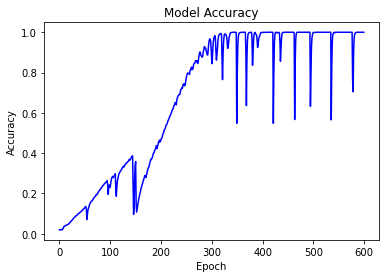

In [45]:
# Plot da Acurácia
plt.plot(history.history['accuracy'], color='blue')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

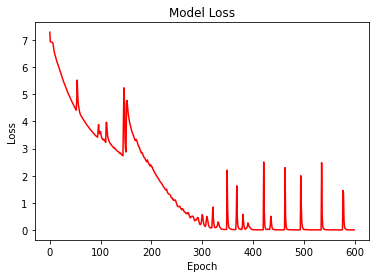

In [46]:
#Plot da Perda
plt.plot(history.history['loss'], color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Parte 5 - Testando o modelo
Finalmente, vamos:
 * Carregar o modelo
 * Gerar textos a partir do modelo treinado

In [63]:
#Parâmetros
model_name = 'fastererick_twitter'


In [64]:
#Carregamento do modelo
model = load_model(f'{model_name}.h5')
tokenizer = load(open(f'{model_name}.p', 'rb'))

In [65]:
#Função para gerar o texto
def generate_text(model,tokenizer, seq_len, seed, num_words):
    
    output_text = []
    
    input_text = seed
    
    for i in range(num_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre') #Padding caso haja menos seq_len do que o total, trunca no inicio da string
        pred_word_index = model.predict_classes(pad_encoded, verbose=0)[0]
        pred_word = tokenizer.index_word[pred_word_index]
        input_text += ' '+pred_word
        
        output_text.append(pred_word)
    
    output_text = ' '.join(output_text)
    output_text = output_text.capitalize()
    return output_text

In [66]:
#Geração do seed
def generate_seed():
    random_pick = random.randint(0, len(text_sequences))
    random_seed = text_sequences[random_pick]
    seed = ' '.join(random_seed)
    return seed

In [70]:
#Geração do texto

num_words = 25
for _ in range(20):
    seed = generate_seed()
    text = generate_text(model,tokenizer,seq_len,seed=seed, num_words=num_words)
    print(f"ErickBot: {text}\n")

ErickBot: Hahahahaha pqp q merda p kkkkkk opa ai sim ei e qdo acabarmos de estudar qdo q vai ter algum rolezinho o/ maldito de modo

ErickBot: Jogaram amanha tomara q a professora nao venha aew demoro pra jgr amanha kkk preguiça de ir dormir hj =/ =/ =/ =/ =/ =/

ErickBot: Zumbizando no tecnico                                                                  

ErickBot:                                                                           

ErickBot: Dia de violão meus agnóstico pq o faster se janta foda s ano falei em novo a guitarra .. .. .. .. .. .. ..

ErickBot: Nenhum na tecnico dormindo com eh tanta galeria na usar violao do tempo agora soh quero passar em csa vou dormir mais que que consegue

ErickBot: Greve to c mto mais pra ouvir as vezes s era se nozes kk ta c a maior preguiça pra n tem q fui pra

ErickBot: Eh do seculo passado!ele terá inspirado videogame =( =( =( =( =( =( =( =( =( =( =( =( =( =( =( =( =( =(

ErickBot: Trabalhos no shopping dia kkkkkkkkkkk eh não é hj el